# Compressor Bottleneck Analysis with NeqSim

This notebook demonstrates process simulation and optimization with NeqSim, including:
- Building a multi-train gas processing system (4 inlet trains → 3 compressor trains)
- Configuring compressors with performance charts and VFD motor drivers
- Analyzing equipment capacity utilization and detecting bottlenecks
- Two-stage production optimization (load balancing + throughput maximization)
- Visualizing compressor operating points on performance curves

## 1. Import Required Libraries and Setup NeqSim

Import NeqSim classes using direct Java access via jpype. This includes ProcessSystem, Stream, Splitter, Compressor, Separator, PipeBeggsAndBrills, Manifold, CompressorDriver, and StreamSaturatorUtil.

In [ ]:
import neqsim
from neqsim import jneqsim

# Import Java classes for direct access
SystemPrEos = jneqsim.thermo.system.SystemPrEos
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Splitter = jneqsim.process.equipment.splitter.Splitter
Compressor = jneqsim.process.equipment.compressor.Compressor
CompressorDriver = jneqsim.process.equipment.compressor.CompressorDriver
DriverType = jneqsim.process.equipment.compressor.DriverType
Separator = jneqsim.process.equipment.separator.Separator
ThreePhaseSeparator = jneqsim.process.equipment.separator.ThreePhaseSeparator
PipeBeggsAndBrills = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills
Manifold = jneqsim.process.equipment.manifold.Manifold
StreamSaturatorUtil = jneqsim.process.equipment.util.StreamSaturatorUtil

## 2. Create Test Fluid System

Create a SystemPrEos fluid with natural gas composition using the Peng-Robinson equation of state.

In [ ]:
# Create test fluid with natural gas composition
test_system = SystemPrEos(298.15, 10.0)  # Temperature in K, Pressure in bara
test_system.addComponent("nitrogen", 0.0015)
test_system.addComponent("methane", 0.925)
test_system.addComponent("ethane", 0.03563)
test_system.addComponent("propane", 0.00693)
test_system.addComponent("water", 0.001)
test_system.setMixingRule("classic")
test_system.setMultiPhaseCheck(True)

## 3. Build Inlet Stream and Water Saturator

Create the inlet stream with specified flow rate, temperature, and pressure. Add a water saturator to saturate the gas stream with water vapor.

In [210]:
# Create process system
process_system = ProcessSystem()

# Create inlet stream
inlet_stream = Stream("Inlet Stream", test_system)
inlet_stream.setFlowRate(2097870.58288790, "kg/hr")
inlet_stream.setTemperature(48.5, "C")
inlet_stream.setPressure(37.16, "bara")
inlet_stream.run()
process_system.add(inlet_stream)

# Saturate the stream with water
saturator = StreamSaturatorUtil("Water Saturator", inlet_stream)
saturator.run()
process_system.add(saturator)

# Get the water-saturated outlet stream
saturated_stream = Stream("Saturated Stream", saturator.getOutletStream())
saturated_stream.run()
process_system.add(saturated_stream)

print(f"Inlet Stream:")
print(f"  Flow rate: {inlet_stream.getFlowRate('kg/hr'):.0f} kg/hr")
print(f"  Temperature: {inlet_stream.getTemperature('C'):.1f} °C")
print(f"  Pressure: {inlet_stream.getPressure('bara'):.2f} bara")

Inlet Stream:
  Flow rate: 2097871 kg/hr
  Temperature: 48.5 °C
  Pressure: 37.16 bara


## 4. Create Splitter and Processing Trains

Create a 4-way splitter and processing trains. Each train consists of an inlet pipe, three-phase separator, and outlet pipe.

In [211]:
def create_processing_train(train_name, inlet_stream, process_system):
    """Creates a processing train with pipe, separator, and outlet pipe."""
    
    # Inlet pipe
    inlet_pipe = PipeBeggsAndBrills(train_name + " Inlet Pipe", inlet_stream)
    inlet_pipe.setLength(100.0)  # meters
    inlet_pipe.setDiameter(0.7)  # meters
    inlet_pipe.setPipeWallRoughness(15e-6)
    inlet_pipe.setElevation(0)
    inlet_pipe.run()
    process_system.add(inlet_pipe)
    
    # Three-phase separator
    separator = ThreePhaseSeparator(train_name + " Separator", inlet_pipe.getOutletStream())
    separator.run()
    process_system.add(separator)
    
    # Outlet pipe
    outlet_pipe = PipeBeggsAndBrills(train_name + " Outlet Pipe", separator.getGasOutStream())
    outlet_pipe.setLength(100.0)  # meters
    outlet_pipe.setDiameter(0.7)  # meters
    outlet_pipe.setPipeWallRoughness(15e-6)
    outlet_pipe.setElevation(0)
    outlet_pipe.setNumberOfIncrements(10)
    outlet_pipe.run()
    process_system.add(outlet_pipe)
    
    return outlet_pipe

# Create first splitter
splitter = Splitter("Test Splitter", saturated_stream)
splitter.setSplitFactors([0.25, 0.25, 0.25, 0.25])
splitter.run()
process_system.add(splitter)

# Create processing trains for each split stream
train1_outlet = create_processing_train("Train1", splitter.getSplitStream(0), process_system)
train2_outlet = create_processing_train("Train2", splitter.getSplitStream(1), process_system)
train3_outlet = create_processing_train("Train3", splitter.getSplitStream(2), process_system)
train4_outlet = create_processing_train("Train4", splitter.getSplitStream(3), process_system)

print("Created 4 processing trains with pipes and separators")

Created 4 processing trains with pipes and separators


## 5. Build Final Separator and Second Splitter

Combine all four processing train outlets in a final separator, then split to three compressor trains.

In [212]:
# Create final separator combining all train outlets
final_separator = ThreePhaseSeparator("Final Separator")
final_separator.addStream(train1_outlet.getOutletStream())
final_separator.addStream(train2_outlet.getOutletStream())
final_separator.addStream(train3_outlet.getOutletStream())
final_separator.addStream(train4_outlet.getOutletStream())
final_separator.setInternalDiameter(3.0)
final_separator.run()
process_system.add(final_separator)

# Create second splitter for compressor trains (slightly unequal distribution)
splitter2 = Splitter("Test Splitter2", final_separator.getGasOutStream())
splitter2.setSplitFactors([0.95 / 3.0, 1.0 / 3.0, 1.05 / 3.0])
splitter2.run()
process_system.add(splitter2)

print(f"Final separator internal diameter: {final_separator.getInternalDiameter()} m")
print(f"Splitter 2 split factors: {[0.95/3.0, 1.0/3.0, 1.05/3.0]}")

Final separator internal diameter: 3.0 m
Splitter 2 split factors: [0.31666666666666665, 0.3333333333333333, 0.35000000000000003]


## 6. Create Upstream Compressor Trains

Create three compressor trains, each with inlet pipe, separator, outlet pipe, and compressor.

In [213]:
def create_upstream_compressors(train_name, inlet_stream, process_system):
    """Creates an upstream compressor train with pipes, separator, and compressor."""
    
    # Print inlet conditions
    print(f"\n=== {train_name} INLET CONDITIONS ===")
    print(f"Inlet Pressure: {inlet_stream.getPressure('bara'):.2f} bara")
    print(f"Inlet Flow: {inlet_stream.getFlowRate('kg/hr'):.0f} kg/hr")
    print(f"Gas Density: {inlet_stream.getFluid().getDensity('kg/m3'):.2f} kg/m3")
    
    # Inlet pipe
    inlet_pipe = PipeBeggsAndBrills(train_name + " ups Pipe", inlet_stream)
    inlet_pipe.setLength(100)  # meters
    inlet_pipe.setDiameter(0.875)  # meters
    inlet_pipe.setPipeWallRoughness(15e-6)
    inlet_pipe.setElevation(0)
    inlet_pipe.run()
    process_system.add(inlet_pipe)
    
    # Separator
    separator = Separator(train_name + " ups Separator", inlet_pipe.getOutletStream())
    separator.run()
    process_system.add(separator)
    
    # Outlet pipe
    outlet_pipe = PipeBeggsAndBrills(train_name + " ups Outlet Pipe", separator.getGasOutStream())
    outlet_pipe.setLength(50.0)  # meters
    outlet_pipe.setDiameter(0.85)  # meters
    outlet_pipe.setPipeWallRoughness(15e-6)
    outlet_pipe.setElevation(0)
    outlet_pipe.run()
    process_system.add(outlet_pipe)
    
    # Compressor
    compressor = Compressor(train_name + " Compressor", outlet_pipe.getOutletStream())
    compressor.setOutletPressure(110.0, "bara")
    compressor.setUsePolytropicCalc(True)
    compressor.setPolytropicEfficiency(0.85)
    compressor.setSpeed(8000)
    compressor.run()
    process_system.add(compressor)

    # Outlet pipe
    outlet_pipe2 = PipeBeggsAndBrills(train_name + " ups Outlet Pipe2", compressor.getOutletStream())
    outlet_pipe2.setLength(50.0)  # meters
    outlet_pipe2.setDiameter(0.85)  # meters
    outlet_pipe2.setPipeWallRoughness(15e-6)
    outlet_pipe2.setElevation(0)
    outlet_pipe2.run()
    process_system.add(outlet_pipe2)
    
    return outlet_pipe2.getOutletStream()

# Create upstream compressor trains
ups1_outlet = create_upstream_compressors("ups1", splitter2.getSplitStream(0), process_system)
ups2_outlet = create_upstream_compressors("ups2", splitter2.getSplitStream(1), process_system)
ups3_outlet = create_upstream_compressors("ups3", splitter2.getSplitStream(2), process_system)


=== ups1 INLET CONDITIONS ===
Inlet Pressure: 37.08 bara
Inlet Flow: 665658 kg/hr
Gas Density: 24.68 kg/m3

=== ups2 INLET CONDITIONS ===
Inlet Pressure: 37.08 bara
Inlet Flow: 700692 kg/hr
Gas Density: 24.68 kg/m3

=== ups3 INLET CONDITIONS ===
Inlet Pressure: 37.08 bara
Inlet Flow: 735727 kg/hr
Gas Density: 24.68 kg/m3


## 7. Create Manifold and Run Process System

Create a manifold to combine all three compressor outlets and run the complete process system.

In [214]:
# Create manifold combining compressor outlets
manifold = Manifold("Compressor Outlet Manifold")
manifold.addStream(ups1_outlet)
manifold.addStream(ups2_outlet)
manifold.addStream(ups3_outlet)
manifold.setSplitFactors([1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0])
manifold.setHeaderInnerDiameter(1.5)
manifold.setBranchInnerDiameter(0.6)
manifold.run()
process_system.add(manifold)

# Run the process system
process_system.run()

print("\nProcess system created and run successfully!")
print(f"Total unit operations: {process_system.getUnitOperations().size()}")


Process system created and run successfully!
Total unit operations: 34


## 8. Auto-size Equipment

Auto-size separators, compressors, and manifolds based on current operating conditions.

In [215]:
# Auto-size separators and compressors
for equipment in process_system.getUnitOperations():
    if isinstance(equipment, Separator):
        equipment.autoSize()
    elif isinstance(equipment, Compressor):
        equipment.autoSize()
    elif isinstance(equipment, Manifold):
        equipment.autoSize()

print("Equipment auto-sizing complete")

Equipment auto-sizing complete


## 9. Configure Compressor Charts and Drivers

Load compressor performance charts from JSON files and configure VFD motor drivers with tabular speed-dependent power curves using `setMaxPowerSpeedCurve(speeds, powers, unit)`.

In [216]:
# Configure ups1 compressor with driver curve
ups1_comp = process_system.getUnit("ups1 Compressor")
ups1_comp.getMechanicalDesign().setMaxDesignPower(50000.0)
ups1_comp.loadCompressorChartFromJson("C:/Users/ESOL/Documents/GitHub/neqsim2/src/test/resources/compressor_curves/compressor_curve_ups2.json")
ups1_comp.setSolveSpeed(True)

# ups1 and ups2: Same compressor curve, 44.4 MW max at 7383 RPM
driver1 = CompressorDriver(DriverType.VFD_MOTOR, 44400.0)
driver1.setRatedSpeed(7383.0)
speeds_ups1 = [4922.0, 5200.0, 5500.0, 5800.0, 6100.0, 6400.0, 6700.0, 6900.0, 7100.0, 7200.0, 7300.0, 7383.0]
powers_ups1 = [28.0, 30.5, 33.5, 36.5, 39.5, 42.0, 43.8, 44.2, 44.35, 44.38, 44.40, 44.40]
driver1.setMaxPowerSpeedCurve(speeds_ups1, powers_ups1, "MW")
ups1_comp.setDriver(driver1)

# Configure ups2 compressor (same driver specs as ups1)
ups2_comp = process_system.getUnit("ups2 Compressor")
ups2_comp.getMechanicalDesign().setMaxDesignPower(50000.0)
ups2_comp.loadCompressorChartFromJson("C:/Users/ESOL/Documents/GitHub/neqsim2/src/test/resources/compressor_curves/compressor_curve_ups2.json")
ups2_comp.setSolveSpeed(True)
driver2 = CompressorDriver(DriverType.VFD_MOTOR, 44400.0)
driver2.setRatedSpeed(7383.0)
driver2.setMaxPowerSpeedCurve(speeds_ups1, powers_ups1, "MW")
ups2_comp.setDriver(driver2)

# Configure ups3 compressor (different driver specs - 50 MW max at 6726 RPM)
ups3_comp = process_system.getUnit("ups3 Compressor")
ups3_comp.getMechanicalDesign().setMaxDesignPower(55000.0)
ups3_comp.loadCompressorChartFromJson("C:/Users/ESOL/Documents/GitHub/neqsim2/src/test/resources/compressor_curves/compressor_curve_ups3.json")
ups3_comp.setSolveSpeed(True)
driver3 = CompressorDriver(DriverType.VFD_MOTOR, 50000.0)
driver3.setRatedSpeed(6726.3)
speeds_ups3 = [4484.0, 4700.0, 4950.0, 5200.0, 5450.0, 5700.0, 5950.0, 6150.0, 6350.0, 6500.0, 6600.0, 6680.0, 6726.0]
powers_ups3 = [30.0, 33.0, 36.5, 40.0, 43.5, 46.5, 48.5, 49.2, 49.6, 49.85, 49.93, 49.98, 50.0]
driver3.setMaxPowerSpeedCurve(speeds_ups3, powers_ups3, "MW")
ups3_comp.setDriver(driver3)

process_system.run()

print("Compressor charts and drivers configured:")
print(f"  ups1: {driver1.getRatedPower():.0f} kW @ {driver1.getRatedSpeed():.0f} RPM")
print(f"  ups2: {driver2.getRatedPower():.0f} kW @ {driver2.getRatedSpeed():.0f} RPM")  
print(f"  ups3: {driver3.getRatedPower():.0f} kW @ {driver3.getRatedSpeed():.0f} RPM")

Compressor charts and drivers configured with tabular power curves:
  ups1: Rated Power = 44400 kW, Rated Speed = 7383 RPM
  ups2: Rated Power = 44400 kW, Rated Speed = 7383 RPM
  ups3: Rated Power = 50000 kW, Rated Speed = 6726 RPM

Driver power curve data points:
  ups1/ups2 (speeds, powers): 12 data points from 4922-7383 RPM, 28-44.4 MW
  ups3 (speeds, powers):      13 data points from 4484-6726 RPM, 30-50 MW


## 10. Verify Compressor Inlet Flows

In [165]:
# Verify compressor inlet flow
ups1_flow = process_system.getUnit("ups1 Compressor").getInletStream().getFlowRate("kg/hr")
ups2_flow = process_system.getUnit("ups2 Compressor").getInletStream().getFlowRate("kg/hr")
ups3_flow = process_system.getUnit("ups3 Compressor").getInletStream().getFlowRate("kg/hr")

print("=== COMPRESSOR INLET FLOWS ===")
print(f"UPS-1 inlet: {ups1_flow:,.0f} kg/hr")
print(f"UPS-2 inlet: {ups2_flow:,.0f} kg/hr")
print(f"UPS-3 inlet: {ups3_flow:,.0f} kg/hr")
print(f"Total:       {ups1_flow + ups2_flow + ups3_flow:,.0f} kg/hr")

=== COMPRESSOR INLET FLOWS ===
UPS-1 inlet: 665,658 kg/hr
UPS-2 inlet: 700,692 kg/hr
UPS-3 inlet: 735,727 kg/hr
Total:       2,102,077 kg/hr


## 11. Analyze Pipe Velocities

In [166]:
print("=== PIPE VELOCITY ANALYSIS ===")
max_allowed_velocity = 30.0  # m/s - max for gas pipes

print(f"{'Pipe Name':<30}  {'Velocity':>10}  {'Diameter':>10}  {'Status':>8}")
print(f"{'':<30}  {'(m/s)':>10}  {'(m)':>10}  {''}")
print("-" * 65)

for equipment in process_system.getUnitOperations():
    class_name = equipment.getClass().getSimpleName()
    if class_name == "PipeBeggsAndBrills":
        pipe = equipment
        v_max = max(float(pipe.getInletSuperficialVelocity()), float(pipe.getOutletSuperficialVelocity()))
        diameter = float(pipe.getDiameter())
        status = "HIGH!" if v_max > max_allowed_velocity else "OK"
        print(f"{str(pipe.getName()):<30}  {v_max:>10.1f}  {diameter:>10.2f}  {status:>8}")

=== PIPE VELOCITY ANALYSIS ===
Pipe Name                         Velocity    Diameter    Status
                                     (m/s)         (m)  
-----------------------------------------------------------------
Train1 Inlet Pipe                     15.3        0.70        OK
Train1 Outlet Pipe                    15.4        0.70        OK
Train2 Inlet Pipe                     15.3        0.70        OK
Train2 Outlet Pipe                    15.4        0.70        OK
Train3 Inlet Pipe                     15.3        0.70        OK
Train3 Outlet Pipe                    15.4        0.70        OK
Train4 Inlet Pipe                     15.3        0.70        OK
Train4 Outlet Pipe                    15.4        0.70        OK
ups1 ups Pipe                         12.5        0.88        OK
ups1 ups Outlet Pipe                  13.2        0.85        OK
ups1 ups Outlet Pipe2                  6.1        0.85        OK
ups2 ups Pipe                         13.1        0.88        OK
u

## 12. Equipment Capacity Utilization

In [167]:
print("=== EQUIPMENT CAPACITY UTILIZATION ===")
utilization_summary = process_system.getCapacityUtilizationSummary()

for entry in utilization_summary.entrySet():
    print(entry.getKey(), entry.getValue())

=== EQUIPMENT CAPACITY UTILIZATION ===
Train1 Inlet Pipe 76.74617224361391
Train1 Separator 81.68050502274912
Train1 Outlet Pipe 76.83148607573283
Train2 Inlet Pipe 76.74617224361391
Train2 Separator 81.68050502274912
Train2 Outlet Pipe 76.83148607573283
Train3 Inlet Pipe 76.74617224361391
Train3 Separator 81.68050502274912
Train3 Outlet Pipe 76.83148607573283
Train4 Inlet Pipe 76.74617224361391
Train4 Separator 81.68050502274912
Train4 Outlet Pipe 76.83148607573283
Final Separator 81.67981142756156
ups1 ups Pipe 62.320081143007464
ups1 ups Separator 81.67945744800255
ups1 ups Outlet Pipe 66.06162574879428
ups1 Compressor 92.07869568237953
ups1 ups Outlet Pipe2 30.340727095429333
ups2 ups Pipe 65.60404406050894
ups2 ups Separator 81.6794198205015
ups2 ups Outlet Pipe 69.54518871251108
ups2 Compressor 97.31471975353377
ups2 ups Outlet Pipe2 31.96883851866427
ups3 ups Pipe 68.8886128386981
ups3 ups Separator 81.67938029693596
ups3 ups Outlet Pipe 73.02976809813809
ups3 Compressor 89.6791

## 13. Compressor Power and Margins Analysis

In [168]:
comp = process_system.getUnit("ups1 Compressor")

if comp is not None:
    power_kw = comp.getPower("kW")
    max_power = comp.getMechanicalDesign().maxDesignPower
    
    print("=== COMPRESSOR POWER ===")
    print(f"Compressor: {comp.getName()}")
    print(f"Power: {power_kw:.2f} kW ({power_kw/1000:.2f} MW)")
    if max_power > 0:
        print(f"Max Design Power: {max_power:.2f} kW ({max_power/1000:.2f} MW)")
        print(f"Power Utilization: {(power_kw / max_power) * 100:.2f}%")
    
    print("\n=== COMPRESSOR MARGINS ===")
    print(f"Speed: {comp.getSpeed():.0f} RPM")
    print(f"Max Speed: {comp.getMaximumSpeed():.0f} RPM")
    print(f"Min Speed: {comp.getMinimumSpeed():.0f} RPM")
    print(f"Chart Max Speed: {comp.getCompressorChart().getMaxSpeedCurve():.0f} RPM")
    print(f"Chart Min Speed: {comp.getCompressorChart().getMinSpeedCurve():.0f} RPM")
    print(f"Polytropic Head: {comp.getPolytropicFluidHead():.0f} J/kg")
    print(f"Polytropic Efficiency: {comp.getPolytropicEfficiency() * 100:.1f}%")
    print(f"Distance to Surge: {comp.getDistanceToSurge() * 100:.2f}%")
    print(f"Distance to Stonewall: {comp.getDistanceToStoneWall() * 100:.2f}%")
    print(f"Inlet Volume Flow: {comp.getInletStream().getFlowRate('m3/hr'):.0f} m3/hr")
    print(f"Inlet Pressure: {comp.getInletStream().getPressure('bara'):.2f} bara")
    print(f"Outlet Pressure: {comp.getOutletStream().getPressure('bara'):.2f} bara")

=== COMPRESSOR POWER ===
Compressor: ups1 Compressor
Power: 40862.51 kW (40.86 MW)
Max Design Power: 50000.00 kW (50.00 MW)
Power Utilization: 81.73%

=== COMPRESSOR MARGINS ===
Speed: 7193 RPM
Max Speed: 7383 RPM
Min Speed: 4922 RPM
Chart Max Speed: 7383 RPM
Chart Min Speed: 4922 RPM
Polytropic Head: 185 J/kg
Polytropic Efficiency: 83.9%
Distance to Surge: 47.44%
Distance to Stonewall: 60.83%
Inlet Volume Flow: 26990 m3/hr
Inlet Pressure: 37.05 bara
Outlet Pressure: 110.00 bara


## 14. Driver Curve Information

In [169]:
print("=== DRIVER CURVE (Speed-Dependent Max Power) ===")

for equipment in process_system.getUnitOperations():
    if isinstance(equipment, Compressor):
        compressor = equipment
        driver = compressor.getDriver()
        if driver is not None:
            print(f"\nCompressor: {compressor.getName()}")
            print(f"  Driver Type: {driver.getDriverType()}")
            print(f"  Rated Power: {driver.getRatedPower():.0f} kW")
            print(f"  Rated Speed: {driver.getRatedSpeed():.0f} RPM")
            print(f"  Current Speed: {compressor.getSpeed():.0f} RPM")
            max_power_at_speed = driver.getMaxAvailablePowerAtSpeed(compressor.getSpeed())
            print(f"  Max Power at Current Speed: {max_power_at_speed:.0f} kW")
            print(f"  Actual Power: {compressor.getPower('kW'):.0f} kW")
            power_utilization = compressor.getPower("kW") / max_power_at_speed * 100.0
            print(f"  Power Utilization (vs speed-dependent max): {power_utilization:.1f}%")

=== DRIVER CURVE (Speed-Dependent Max Power) ===

Compressor: ups1 Compressor
  Driver Type: VFD_MOTOR
  Rated Power: 44400 kW
  Rated Speed: 7383 RPM
  Current Speed: 7193 RPM
  Max Power at Current Speed: 44378 kW
  Actual Power: 40863 kW
  Power Utilization (vs speed-dependent max): 92.1%

Compressor: ups2 Compressor
  Driver Type: VFD_MOTOR
  Rated Power: 44400 kW
  Rated Speed: 7383 RPM
  Current Speed: 7252 RPM
  Max Power at Current Speed: 44390 kW
  Actual Power: 43198 kW
  Power Utilization (vs speed-dependent max): 97.3%

Compressor: ups3 Compressor
  Driver Type: VFD_MOTOR
  Rated Power: 50000 kW
  Rated Speed: 6726 RPM
  Current Speed: 6270 RPM
  Max Power at Current Speed: 49441 kW
  Actual Power: 44338 kW
  Power Utilization (vs speed-dependent max): 89.7%


## 15. Compressor Capacity Constraints

In [170]:
# Display capacity constraints for all compressors
print("=== COMPRESSOR CAPACITY CONSTRAINTS ===")
for equipment in process_system.getUnitOperations():
    if isinstance(equipment, Compressor):
        comp = equipment
        print(f"\n{comp.getName()}:")
        constraints = comp.getCapacityConstraints()
        for entry in constraints.entrySet():
            c = entry.getValue()
            constraint_type = "MIN" if c.isMinimumConstraint() else "MAX"
            print(f"  {str(entry.getKey()):18s}: {c.getUtilizationPercent():5.1f}% util, "
                  f"current={c.getCurrentValue():.2f}, limit={c.getDisplayDesignValue():.2f} ({constraint_type})")

=== COMPRESSOR CAPACITY CONSTRAINTS ===

ups1 Compressor:
  speed             :  89.9% util, current=7192.70, limit=8000.00 (MAX)
  minSpeed          :  74.1% util, current=7192.70, limit=5333.33 (MIN)
  power             :  92.1% util, current=92.08, limit=100.00 (MAX)
  surgeMargin       :  67.8% util, current=67.82, limit=100.00 (MAX)
  stonewallMargin   :  62.2% util, current=62.18, limit=100.00 (MAX)

ups2 Compressor:
  speed             :  90.7% util, current=7252.37, limit=8000.00 (MAX)
  minSpeed          :  73.5% util, current=7252.37, limit=5333.33 (MIN)
  power             :  97.3% util, current=97.31, limit=100.00 (MAX)
  surgeMargin       :  64.5% util, current=64.47, limit=100.00 (MAX)
  stonewallMargin   :  65.4% util, current=65.43, limit=100.00 (MAX)

ups3 Compressor:
  speed             :  78.4% util, current=6270.33, limit=8000.00 (MAX)
  minSpeed          :  85.1% util, current=6270.33, limit=5333.33 (MIN)
  power             :  89.7% util, current=89.68, limit=100.

In [171]:
# Initialize and display pipe capacity constraints
print("=== PIPE CAPACITY ANALYSIS ===")

for equipment in process_system.getUnitOperations():
    class_name = equipment.getClass().getSimpleName()
    if class_name == "PipeBeggsAndBrills":
        pipe = equipment
        pipe.initMechanicalDesign()
        if pipe.getMechanicalDesign().getMaxDesignVelocity() <= 0:
            pipe.getMechanicalDesign().setMaxDesignVelocity(20.0)  # 20 m/s default
        
        v_max = max(float(pipe.getInletSuperficialVelocity()), float(pipe.getOutletSuperficialVelocity()))
        max_design_v = float(pipe.getMechanicalDesign().getMaxDesignVelocity())
        util = (v_max / max_design_v) * 100 if max_design_v > 0 else 0
        print(f"{str(pipe.getName()):30s}: {v_max:5.1f} m/s (max {max_design_v:.0f} m/s), {util:5.1f}% util")

=== PIPE CAPACITY ANALYSIS ===
Train1 Inlet Pipe             :  15.3 m/s (max 20 m/s),  76.7% util
Train1 Outlet Pipe            :  15.4 m/s (max 20 m/s),  76.8% util
Train2 Inlet Pipe             :  15.3 m/s (max 20 m/s),  76.7% util
Train2 Outlet Pipe            :  15.4 m/s (max 20 m/s),  76.8% util
Train3 Inlet Pipe             :  15.3 m/s (max 20 m/s),  76.7% util
Train3 Outlet Pipe            :  15.4 m/s (max 20 m/s),  76.8% util
Train4 Inlet Pipe             :  15.3 m/s (max 20 m/s),  76.7% util
Train4 Outlet Pipe            :  15.4 m/s (max 20 m/s),  76.8% util
ups1 ups Pipe                 :  12.5 m/s (max 20 m/s),  62.3% util
ups1 ups Outlet Pipe          :  13.2 m/s (max 20 m/s),  66.1% util
ups1 ups Outlet Pipe2         :   6.1 m/s (max 20 m/s),  30.3% util
ups2 ups Pipe                 :  13.1 m/s (max 20 m/s),  65.6% util
ups2 ups Outlet Pipe          :  13.9 m/s (max 20 m/s),  69.5% util
ups2 ups Outlet Pipe2         :   6.4 m/s (max 20 m/s),  32.0% util
ups3 ups Pipe    

## 16. Bottleneck Detection

In [172]:
# Equipment near capacity limit (>90%)
print("=== EQUIPMENT NEAR CAPACITY LIMIT (>90%) ===")
near_limit = process_system.getEquipmentNearCapacityLimit()
if near_limit.isEmpty():
    print("No equipment near capacity limit")
else:
    for name in near_limit:
        print(f"  - {name}")

# Bottleneck detection
bottleneck = process_system.findBottleneck()
print("\n=== BOTTLENECK ANALYSIS ===")
if bottleneck is not None and bottleneck.hasBottleneck():
    print(f"Bottleneck Equipment: {bottleneck.getEquipmentName()}")
    print(f"Constraint: {bottleneck.getConstraintName()}")
    print(f"Utilization: {bottleneck.getUtilizationPercent():.2f}%")
else:
    print("No bottleneck detected")

=== EQUIPMENT NEAR CAPACITY LIMIT (>90%) ===
  - ups1 Compressor
  - ups2 Compressor

=== BOTTLENECK ANALYSIS ===
Bottleneck Equipment: ups2 Compressor
Constraint: power
Utilization: 97.31%


## 17. Production Optimization

Production optimization using NeqSim's `ProductionOptimizer`:
- Single-variable optimization (flow rate)
- Two-stage optimization (load balancing + throughput maximization)

In [ ]:
from jpype import JImplements, JOverride
import jpype

# Import ProductionOptimizer and inner classes
ProductionOptimizer = jneqsim.process.util.optimizer.ProductionOptimizer
OptimizationConfig = ProductionOptimizer.OptimizationConfig
OptimizationObjective = ProductionOptimizer.OptimizationObjective
OptimizationResult = ProductionOptimizer.OptimizationResult
ManipulatedVariable = ProductionOptimizer.ManipulatedVariable
ParetoResult = ProductionOptimizer.ParetoResult
SearchMode = ProductionOptimizer.SearchMode
ObjectiveType = ProductionOptimizer.ObjectiveType

# Import Java collections helpers
Collections = jpype.JClass("java.util.Collections")
Arrays = jpype.JClass("java.util.Arrays")
JDouble = jpype.JClass("java.lang.Double")

### 17.1 Single-Variable Optimization (Flow Rate)

In [219]:
# Reset inlet flow rate to original value and re-run system
inlet_stream.setFlowRate(2097870.58288790, "kg/hr")
process_system.run()

# Store original flow rate for comparison
original_flow = inlet_stream.getFlowRate("kg/hr")
current_flow = original_flow

print(f"Current inlet flow rate: {current_flow:,.0f} kg/hr")

# Initialize mechanical design for all pipes (required for velocity-based capacity checks)
print("\nInitializing mechanical design for pipes...")
for unit in process_system.getUnitOperations():
    if isinstance(unit, PipeBeggsAndBrills):
        unit.initMechanicalDesign()
        unit.getMechanicalDesign().setMaxDesignVelocity(20.0)  # Set max velocity 20 m/s
print("Mechanical design initialized for all pipes.")

# Create optimizer
optimizer = ProductionOptimizer()

# Configure optimization bounds and settings
# Use a smaller range to avoid extreme values that break compressor calculations
low_flow = current_flow * 0.8
high_flow = current_flow * 1.2

# Use BINARY_FEASIBILITY to find maximum feasible rate (respects 100% utilization limit)
single_var_config = OptimizationConfig(low_flow, high_flow) \
    .rateUnit("kg/hr") \
    .tolerance(current_flow * 0.005) \
    .maxIterations(25) \
    .defaultUtilizationLimit(1.0) \
    .searchMode(SearchMode.BINARY_FEASIBILITY)  # Finds max feasible rate

# Define throughput maximization objective
@JImplements("java.util.function.ToDoubleFunction")
class ThroughputEvaluator:
    @JOverride
    def applyAsDouble(self, proc):
        return proc.getUnit("Inlet Stream").getFlowRate("kg/hr")

throughput_objective = OptimizationObjective(
    "throughput", 
    ThroughputEvaluator(), 
    1.0,
    ObjectiveType.MAXIMIZE
)

# Run single-variable optimization
print(f"\nSearch range: {low_flow:,.0f} to {high_flow:,.0f} kg/hr")
print("Running single-variable optimization (BINARY_FEASIBILITY mode)...")
single_var_result = optimizer.optimize(
    process_system, 
    inlet_stream,
    single_var_config, 
    Collections.singletonList(throughput_objective), 
    Collections.emptyList()
)

# Print single-variable optimization results
print("=" * 50)
print("=== SINGLE-VARIABLE OPTIMIZATION RESULTS ===")
print("=" * 50)
print(f"Optimal flow rate: {single_var_result.getOptimalRate():,.0f} kg/hr")
print(f"Feasible: {single_var_result.isFeasible()}")
print(f"Iterations: {single_var_result.getIterations()}")

if single_var_result.getBottleneck() is not None:
    print(f"Bottleneck: {single_var_result.getBottleneck().getName()}")
    print(f"Bottleneck utilization: {single_var_result.getBottleneckUtilization() * 100.0:.1f}%")

# Print iteration history to understand the search
print("\n=== ITERATION HISTORY ===")
for i, rec in enumerate(single_var_result.getIterationHistory()):
    status = "FEASIBLE" if rec.isFeasible() else "INFEASIBLE"
    print(f"  Iter {i+1}: rate={rec.getRate():,.0f} kg/hr, util={rec.getBottleneckUtilization()*100:.1f}%, {status}")

Current inlet flow rate: 2,097,871 kg/hr

Initializing mechanical design for pipes...
Mechanical design initialized for all pipes.

Search range: 1,678,296 to 2,517,445 kg/hr
Running single-variable optimization (BINARY_FEASIBILITY mode)...
=== SINGLE-VARIABLE OPTIMIZATION RESULTS ===
Optimal flow rate: 2,143,762 kg/hr
Feasible: True
Iterations: 6
Bottleneck: ups2 Compressor
Bottleneck utilization: 99.4%

=== ITERATION HISTORY ===
  Iter 1: rate=2,097,871 kg/hr, util=97.3%, FEASIBLE
  Iter 2: rate=2,307,658 kg/hr, util=108.9%, INFEASIBLE
  Iter 3: rate=2,202,764 kg/hr, util=102.9%, INFEASIBLE
  Iter 4: rate=2,150,317 kg/hr, util=100.1%, INFEASIBLE
  Iter 5: rate=2,124,094 kg/hr, util=98.7%, FEASIBLE
  Iter 6: rate=2,137,206 kg/hr, util=99.4%, FEASIBLE
  Iter 7: rate=2,143,762 kg/hr, util=99.4%, FEASIBLE


In [220]:
# Calculate production increase potential
best_feasible_flow = single_var_result.getOptimalRate()
production_increase = best_feasible_flow - original_flow
increase_percent = (production_increase / original_flow) * 100.0

print("=" * 50)
print("=== PRODUCTION POTENTIAL ===")
print("=" * 50)
print(f"Current production: {original_flow:,.0f} kg/hr")
print(f"Maximum production: {best_feasible_flow:,.0f} kg/hr")

if production_increase > 0:
    print(f"Potential increase: {production_increase:,.0f} kg/hr (+{increase_percent:.1f}%)")
elif production_increase < 0:
    print(f"Current production exceeds capacity - reduce by: {abs(production_increase):,.0f} kg/hr ({abs(increase_percent):.1f}%)")
else:
    print("Operating at optimal capacity")

=== PRODUCTION POTENTIAL ===
Current production: 2,097,871 kg/hr
Maximum production: 2,143,762 kg/hr
Potential increase: 45,891 kg/hr (+2.2%)


### 17.2 Two-Stage Optimization

1. **Stage 1: Balance Load** - Optimize split factors to minimize max utilization (Nelder-Mead)
2. **Stage 2: Maximize Throughput** - Binary search for max feasible flow with balanced splits

In [221]:
print("=" * 70)
print("=== TWO-STAGE OPTIMIZATION (RECOMMENDED APPROACH) ===")
print("=" * 70)

# Get the splitter that distributes flow to the 3 compressor trains
compressor_splitter = process_system.getUnit("Test Splitter2")
base_flow = float(original_flow)

# Helper function to get max compressor utilization
def get_max_compressor_utilization():
    max_util = 0.0
    for eq in process_system.getUnitOperations():
        if isinstance(eq, Compressor) and str(eq.getName()).startswith("ups"):
            # Use power utilization as the metric
            driver = eq.getDriver()
            if driver is not None:
                max_power = driver.getMaxAvailablePowerAtSpeed(eq.getSpeed())
                if max_power > 0:
                    util = eq.getPower("kW") / max_power
                    if util > max_util:
                        max_util = util
    return max_util

# Print baseline
print("\n--- BASELINE ---")
print(f"Total flow: {base_flow:,.0f} kg/hr")
original_splits = compressor_splitter.getSplitFactors()
print(f"Split factors: [{original_splits[0]:.4f}, {original_splits[1]:.4f}, {original_splits[2]:.4f}]")
baseline_max_util = get_max_compressor_utilization()
print(f"Max utilization: {baseline_max_util * 100:.2f}%")

# ========================================================================
# STAGE 1: Optimize split factors to balance load (minimize max utilization)
# ========================================================================
print("\n" + "=" * 70)
print("--- STAGE 1: BALANCE LOAD (Optimize Split Factors) ---")
print("=" * 70)

# Define split variables with constraints
@JImplements("java.util.function.BiConsumer")
class Split1Setter:
    @JOverride
    def accept(self, proc, value):
        splitter = proc.getUnit("Test Splitter2")
        current_splits = splitter.getSplitFactors()
        split2 = float(current_splits[1])
        split3 = 1.0 - float(value) - split2
        # Ensure split3 stays in valid range
        if split3 < 0.25:
            split3 = 0.25
        if split3 > 0.42:
            split3 = 0.42
        split2 = 1.0 - float(value) - split3
        splitter.setSplitFactors([float(value), split2, split3])

@JImplements("java.util.function.BiConsumer")
class Split2Setter:
    @JOverride
    def accept(self, proc, value):
        splitter = proc.getUnit("Test Splitter2")
        current_splits = splitter.getSplitFactors()
        split1 = float(current_splits[0])
        split3 = 1.0 - split1 - float(value)
        # Ensure split3 stays in valid range
        if split3 < 0.25:
            split3 = 0.25
        if split3 > 0.42:
            split3 = 0.42
        split1 = 1.0 - float(value) - split3
        splitter.setSplitFactors([split1, float(value), split3])

split1_var = ManipulatedVariable("split1", 0.28, 0.40, "fraction", Split1Setter())
split2_var = ManipulatedVariable("split2", 0.28, 0.40, "fraction", Split2Setter())
split_variables = Arrays.asList(split1_var, split2_var)

# Stage 1 config: Use Nelder-Mead to minimize max utilization
stage1_config = OptimizationConfig(0.28, 0.40) \
    .rateUnit("fraction") \
    .tolerance(0.001) \
    .maxIterations(50) \
    .defaultUtilizationLimit(2.0) \
    .searchMode(SearchMode.NELDER_MEAD_SCORE)

# Objective: MINIMIZE max utilization (negative because optimizer maximizes score)
@JImplements("java.util.function.ToDoubleFunction")
class BalanceEvaluator:
    @JOverride
    def applyAsDouble(self, proc):
        return -get_max_compressor_utilization()  # Negative to minimize

balance_objective = OptimizationObjective(
    "balanceLoad",
    BalanceEvaluator(),
    1.0,
    ObjectiveType.MAXIMIZE  # Max of negative = Min of positive
)

print("Running Stage 1 (load balancing)...")
stage1_result = optimizer.optimize(
    process_system,
    split_variables,
    stage1_config,
    Collections.singletonList(balance_objective),
    Collections.emptyList()
)

# Extract and apply stage 1 results
opt_split1 = float(stage1_result.getDecisionVariables().getOrDefault("split1", JDouble.valueOf(0.333)))
opt_split2 = float(stage1_result.getDecisionVariables().getOrDefault("split2", JDouble.valueOf(0.333)))
opt_split3 = 1.0 - opt_split1 - opt_split2

compressor_splitter.setSplitFactors([opt_split1, opt_split2, opt_split3])
process_system.run()

print(f"Optimized splits: [{opt_split1:.4f}, {opt_split2:.4f}, {opt_split3:.4f}]")
balanced_max_util = get_max_compressor_utilization()
print(f"Balanced max utilization: {balanced_max_util * 100:.2f}%")
print(f"Improvement: {(baseline_max_util - balanced_max_util) * 100:.2f}% reduction")

# ========================================================================
# STAGE 2: Maximize total flow using binary search (deterministic)
# ========================================================================
print("\n" + "=" * 70)
print("--- STAGE 2: MAXIMIZE FLOW (Binary Search) ---")
print("=" * 70)

# Now with balanced splits, use BINARY_FEASIBILITY to find max flow
stage2_config = OptimizationConfig(base_flow * 0.9, base_flow * 1.15) \
    .rateUnit("kg/hr") \
    .tolerance(base_flow * 0.001) \
    .maxIterations(20) \
    .defaultUtilizationLimit(1.0) \
    .searchMode(SearchMode.BINARY_FEASIBILITY)

print("Running Stage 2 (throughput maximization)...")
stage2_result = optimizer.optimize(
    process_system,
    inlet_stream,
    stage2_config,
    Collections.singletonList(throughput_objective),
    Collections.emptyList()
)

print(f"Optimal flow: {stage2_result.getOptimalRate():,.0f} kg/hr")
print(f"Feasible: {stage2_result.isFeasible()}")
if stage2_result.getBottleneck() is not None:
    print(f"Bottleneck: {stage2_result.getBottleneck().getName()}")
    print(f"Bottleneck utilization: {stage2_result.getBottleneckUtilization() * 100:.2f}%")

# Apply final result
inlet_stream.setFlowRate(stage2_result.getOptimalRate(), "kg/hr")
process_system.run()

# Store results for later
best_flow = stage2_result.getOptimalRate()
best_f1, best_f2, best_f3 = opt_split1, opt_split2, opt_split3

=== TWO-STAGE OPTIMIZATION (RECOMMENDED APPROACH) ===

--- BASELINE ---
Total flow: 2,097,871 kg/hr
Split factors: [0.3167, 0.3333, 0.3500]
Max utilization: 99.38%

--- STAGE 1: BALANCE LOAD (Optimize Split Factors) ---
Running Stage 1 (load balancing)...
Optimized splits: [0.3163, 0.3196, 0.3641]
Balanced max utilization: 94.90%
Improvement: 4.48% reduction

--- STAGE 2: MAXIMIZE FLOW (Binary Search) ---
Running Stage 2 (throughput maximization)...
Optimal flow: 2,226,119 kg/hr
Feasible: True
Bottleneck: ups3 Compressor
Bottleneck utilization: 99.94%


In [222]:
# Print final optimized state
print("=" * 70)
print("=== FINAL OPTIMIZED STATE ===")
print("=" * 70)

print(f"\nTotal flow: {best_flow:,.0f} kg/hr")
print(f"Split factors: [{best_f1:.4f}, {best_f2:.4f}, {best_f3:.4f}]")

# Compare with baseline
improvement = (float(best_flow) - float(original_flow)) / float(original_flow) * 100
print(f"\nBaseline flow: {float(original_flow):,.0f} kg/hr")
print(f"Optimized flow: {float(best_flow):,.0f} kg/hr")
print(f"Throughput improvement: {improvement:+.1f}%")

# Show final compressor status
print("\n--- FINAL COMPRESSOR STATUS ---")
for eq in process_system.getUnitOperations():
    if isinstance(eq, Compressor) and str(eq.getName()).startswith("ups"):
        name = str(eq.getName())
        power = eq.getPower("kW")
        speed = eq.getSpeed()
        surge_margin = eq.getDistanceToSurge() * 100
        driver = eq.getDriver()
        power_util = 0.0
        if driver is not None:
            max_power = driver.getMaxAvailablePowerAtSpeed(speed)
            if max_power > 0:
                power_util = power / max_power * 100
        print(f"  {name}: Power={power:,.0f} kW ({power_util:.1f}%), Speed={speed:.0f} RPM, Surge margin={surge_margin:.1f}%")

=== FINAL OPTIMIZED STATE ===

Total flow: 2,226,119 kg/hr
Split factors: [0.3163, 0.3196, 0.3641]

Baseline flow: 2,097,871 kg/hr
Optimized flow: 2,226,119 kg/hr
Throughput improvement: +6.1%

--- FINAL COMPRESSOR STATUS ---
  ups1 Compressor: Power=43,555 kW (98.1%), Speed=7262 RPM, Surge margin=56.2%
  ups2 Compressor: Power=44,062 kW (99.3%), Speed=7276 RPM, Surge margin=57.7%
  ups3 Compressor: Power=49,798 kW (99.9%), Speed=6488 RPM, Surge margin=94.8%


## Constraint Enable/Disable Control

NeqSim allows selective enabling/disabling of capacity constraints for what-if scenarios and focused analysis.

| Equipment | Constraint Names |
|-----------|------------------|
| **Compressor** | `power`, `speed`, `surge`, `stonewall`, `dischargeTemperature` |
| **Pipeline** | `velocity`, `LOF`, `FRMS`, `volumeFlow`, `pressureDrop` |
| **Manifold** | `headerVelocity`, `branchVelocity`, `headerLOF`, `branchLOF` |
| **Separator** | `gasLoadFactor` |

In [ ]:
# Demonstrating Constraint Enable/Disable for key equipment types
print("=" * 70)
print("CONSTRAINT ENABLE/DISABLE CONTROL DEMONSTRATION")
print("=" * 70)

# 1. COMPRESSOR CONSTRAINTS
print("\n1. COMPRESSOR CONSTRAINTS")
print("-" * 40)
compressor = ups1_comp
constraints = compressor.getCapacityConstraints()

print(f"Compressor '{compressor.getName()}' has {constraints.size()} constraints:")
for name in constraints.keySet():
    c = constraints.get(name)
    status = "ENABLED" if c.isEnabled() else "DISABLED"
    display_limit = c.getDisplayDesignValue()
    constraint_type = "MIN" if c.isMinimumConstraint() else "MAX"
    print(f"  - {str(name)}: {status}, Current={c.getCurrentValue():.2f}, Limit={display_limit:.2f} ({constraint_type})")

# Example: Disable surge constraint for what-if scenario
if constraints.containsKey("surgeMargin"):
    constraints.get("surgeMargin").setEnabled(False)
    new_bn = compressor.getBottleneckConstraint()
    print(f"\n  >> With surge disabled, bottleneck is: {str(new_bn.getName()) if new_bn else 'None'}")
    constraints.get("surgeMargin").setEnabled(True)
    print("  >> Re-enabled 'surgeMargin' constraint")

# 2. PIPELINE CONSTRAINTS
print("\n2. PIPELINE CONSTRAINTS")
print("-" * 40)
pipe_constraints = train1_outlet.getCapacityConstraints()
print(f"Pipeline '{train1_outlet.getName()}' has {pipe_constraints.size()} constraints:")
for name in pipe_constraints.keySet():
    c = pipe_constraints.get(name)
    display_limit = c.getDisplayDesignValue()
    limit_str = f"{display_limit:.2f}" if display_limit < 1e6 else "MAX"
    print(f"  - {str(name)}: Current={c.getCurrentValue():.2f}, Limit={limit_str}")

# 3. MANIFOLD CONSTRAINTS
print("\n3. MANIFOLD CONSTRAINTS")
print("-" * 40)
manifold_constraints = manifold.getCapacityConstraints()
print(f"Manifold '{manifold.getName()}' has {manifold_constraints.size()} constraints:")
for name in manifold_constraints.keySet():
    c = manifold_constraints.get(name)
    display_limit = c.getDisplayDesignValue()
    limit_str = f"{display_limit:.2f}" if display_limit < 1e6 else "MAX"
    print(f"  - {str(name)}: Current={c.getCurrentValue():.4f}, Limit={limit_str}")

# 4. PROCESS-WIDE CONSTRAINT STATUS SUMMARY
print("\n4. PROCESS-WIDE CONSTRAINT STATUS")
print("-" * 40)
equipment_list = [ups1_comp, ups2_comp, ups3_comp, train1_outlet, manifold, final_separator]

for unit in equipment_list:
    try:
        unit_constraints = unit.getCapacityConstraints()
        if unit_constraints and unit_constraints.size() > 0:
            enabled = sum(1 for c in unit_constraints.values() if c.isEnabled())
            total = unit_constraints.size()
            bottleneck = unit.getBottleneckConstraint()
            bn_name = str(bottleneck.getName()) if bottleneck else "None"
            max_util = float(unit.getMaxUtilization()) * 100
            print(f"{str(unit.getName()):30s}: {enabled}/{total} enabled, MaxUtil={max_util:5.1f}%, Bottleneck: {bn_name}")
    except Exception as e:
        print(f"{str(unit.getName())}: Error - {e}")

print("\n" + "=" * 70)
print("TIP: Use constraint.setEnabled(False/True) to exclude/include from optimization")
print("=" * 70)

CONSTRAINT ENABLE/DISABLE CONTROL DEMONSTRATION

1. COMPRESSOR CONSTRAINTS
----------------------------------------
Compressor 'ups1 Compressor' has 5 constraints:
  - speed: ENABLED, Current=7262.32, Limit=8000.00 (MAX)
  - minSpeed: ENABLED, Current=7262.32, Limit=5333.33 (MIN)
  - power: ENABLED, Current=98.11, Limit=100.00 (MAX)
  - surgeMargin: ENABLED, Current=64.04, Limit=100.00 (MAX)
  - stonewallMargin: ENABLED, Current=65.89, Limit=100.00 (MAX)

  >> Disabled 'surgeMargin' constraint for what-if analysis
  >> With surge disabled, bottleneck is: power
  >> Re-enabled 'surgeMargin' constraint

2. PIPELINE CONSTRAINTS
----------------------------------------
Pipeline 'Train1 Outlet Pipe' has 3 constraints:
  - velocity: ENABLED, Current=16.31, Limit=20.00
  - LOF: ENABLED, Current=0.00, Limit=1.00
  - FRMS: ENABLED, Current=0.00, Limit=500.00

  >> Disabled 'velocity' constraint
  >> New bottleneck without velocity: velocity
  >> Re-enabled 'velocity' constraint

3. MANIFOLD CON

## Summary

This notebook demonstrated:

1. **Process System Setup**: Building a multi-train gas processing system with 4 inlet trains feeding 3 compressor trains
2. **Compressor Configuration**: Performance charts with VFD motor drivers using tabular speed-dependent power curves
3. **Capacity Analysis**: Monitoring equipment utilization including pipes, manifolds, separators, and compressors
4. **Bottleneck Detection**: Identifying system constraints (surge margin, power, velocity)
5. **Production Optimization**:
   - Single-variable optimization (flow rate) with binary search
   - Two-stage optimization: Balance load (Nelder-Mead) + Maximize throughput (binary search)
6. **Constraint Control**: Enabling/disabling individual constraints for what-if analysis
7. **Visualization**: Compressor performance curves with operating points

### Key API Methods

| Method | Description |
|--------|-------------|
| `equipment.getCapacityConstraints()` | Get all constraints for equipment |
| `constraint.setEnabled(False/True)` | Disable/enable a constraint |
| `equipment.getMaxUtilization()` | Get max utilization as fraction (0-1) |
| `equipment.getBottleneckConstraint()` | Get the limiting constraint |
| `compressor.getCompressorChart()` | Get compressor performance chart data |

## 18. Compressor Performance Curves

Plot compressor performance curves showing initial vs optimized operating points.

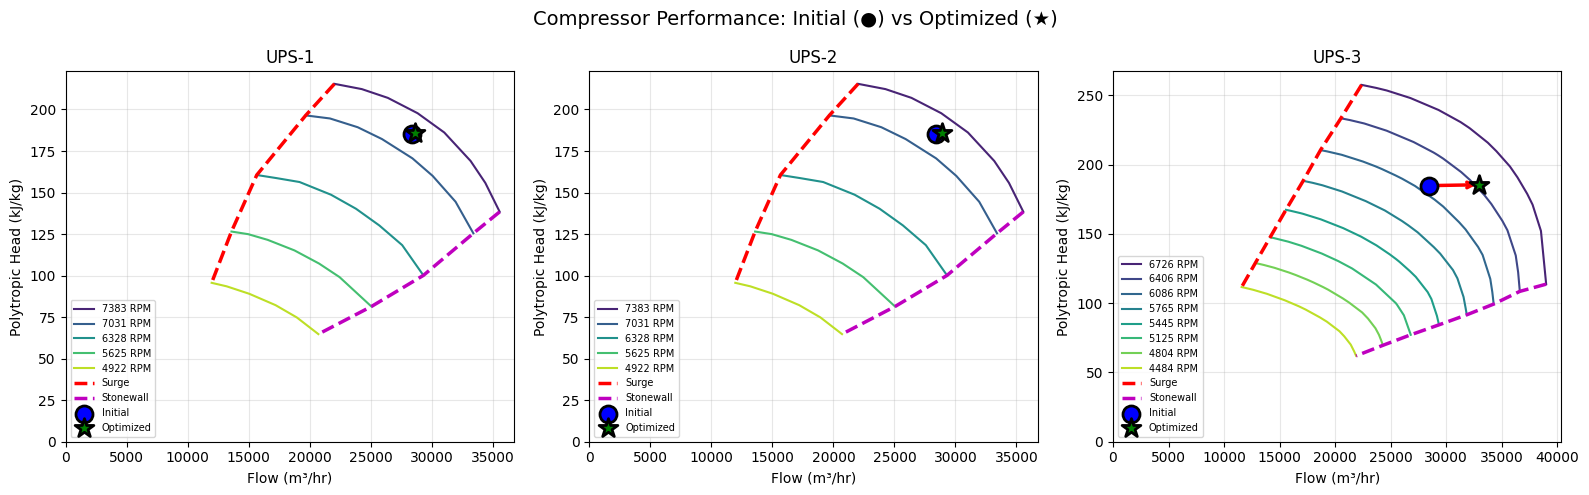


Operating Point & Power Comparison:
Compressor Init Flow    Opt Flow     Init Head   Opt Head    Power      Max Power  Util    
           (m³/hr)      (m³/hr)      (kJ/kg)     (kJ/kg)     (MW)       (MW)       (%)     
----------------------------------------------------------------------------------------------------
UPS-1      28414        28622        185.49      185.56      43.55      44.39      98.1    
UPS-2      28414        28917        185.49      185.60      44.06      44.40      99.2    
UPS-3      28414        32951        184.84      185.47      49.80      49.83      99.9    


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Calculate initial operating points (equal 1/3 split at original flow)
compressor_splitter.setSplitFactors([1.0/3.0, 1.0/3.0, 1.0/3.0])
inlet_stream.setFlowRate(float(original_flow), "kg/hr")
process_system.run()

initial_points = {}
for name, comp in [("UPS-1", ups1_comp), ("UPS-2", ups2_comp), ("UPS-3", ups3_comp)]:
    initial_points[name] = {
        'flow': float(comp.getInletStream().getFlowRate("m3/hr")),
        'head': float(comp.getPolytropicHead("kJ/kg")),
        'speed': float(comp.getSpeed())
    }

# Step 2: Restore optimized state and capture optimized points
compressor_splitter.setSplitFactors([opt_split1, opt_split2, opt_split3])
inlet_stream.setFlowRate(float(best_flow), "kg/hr")
process_system.run()

optimized_points = {}
for name, comp in [("UPS-1", ups1_comp), ("UPS-2", ups2_comp), ("UPS-3", ups3_comp)]:
    optimized_points[name] = {
        'flow': float(comp.getInletStream().getFlowRate("m3/hr")),
        'head': float(comp.getPolytropicHead("kJ/kg")),
        'speed': float(comp.getSpeed())
    }

# Step 3: Plot compressor curves
def plot_compressor_curve(ax, compressor, comp_name, initial_pt, optimized_pt):
    """Plot compressor performance curves with operating points."""
    chart = compressor.getCompressorChart()
    if chart is None:
        ax.text(0.5, 0.5, "No chart data", transform=ax.transAxes, ha='center')
        return
    
    speeds = list(chart.getSpeeds())
    flow_data, head_data = chart.getFlows(), chart.getHeads()
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(speeds)))
    
    surge_pts, stonewall_pts = [], []
    for i, speed in enumerate(speeds):
        try:
            flows, heads = list(flow_data[i]), list(head_data[i])
            if flows and heads:
                ax.plot(flows, heads, '-', color=colors[i], lw=1.5, label=f'{speed:.0f} RPM')
                surge_pts.append((flows[0], heads[0]))
                stonewall_pts.append((flows[-1], heads[-1]))
        except:
            pass
    
    # Surge and stonewall boundaries
    if len(surge_pts) > 1:
        sf, sh = zip(*surge_pts)
        ax.plot(sf, sh, 'r--', lw=2.5, label='Surge')
    if len(stonewall_pts) > 1:
        swf, swh = zip(*stonewall_pts)
        ax.plot(swf, swh, 'm--', lw=2.5, label='Stonewall')
    
    # Operating points
    ax.scatter(initial_pt['flow'], initial_pt['head'], c='blue', s=150, marker='o', 
               edgecolors='black', lw=2, label='Initial', zorder=5)
    ax.scatter(optimized_pt['flow'], optimized_pt['head'], c='green', s=200, marker='*', 
               edgecolors='black', lw=2, label='Optimized', zorder=5)
    ax.annotate('', xy=(optimized_pt['flow'], optimized_pt['head']),
                xytext=(initial_pt['flow'], initial_pt['head']),
                arrowprops=dict(arrowstyle='->', color='red', lw=2.5))
    
    ax.set_xlabel('Flow (m³/hr)')
    ax.set_ylabel('Polytropic Head (kJ/kg)')
    ax.set_title(comp_name)
    ax.legend(loc='lower left', fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
compressors = [("UPS-1", ups1_comp), ("UPS-2", ups2_comp), ("UPS-3", ups3_comp)]

for ax, (name, comp) in zip(axes, compressors):
    plot_compressor_curve(ax, comp, name, initial_points[name], optimized_points[name])

plt.suptitle('Compressor Performance: Initial (●) vs Optimized (★)', fontsize=14)
plt.tight_layout()
plt.show()

# Step 4: Print comparison table
print("\n" + "=" * 100)
print("Operating Point & Power Comparison:")
print("=" * 100)
print(f"{'Compressor':<10} {'Init Flow':<12} {'Opt Flow':<12} {'Init Head':<11} {'Opt Head':<11} {'Power':<10} {'Max Power':<10} {'Util':<8}")
print(f"{'':10} {'(m³/hr)':<12} {'(m³/hr)':<12} {'(kJ/kg)':<11} {'(kJ/kg)':<11} {'(MW)':<10} {'(MW)':<10} {'(%)':<8}")
print("-" * 100)
for name, comp in compressors:
    init, opt = initial_points[name], optimized_points[name]
    power_mw = float(comp.getPower("kW")) / 1000.0
    driver = comp.getDriver()
    max_power_mw = driver.getMaxAvailablePowerAtSpeed(comp.getSpeed()) / 1000.0 if driver else 0
    util = (power_mw / max_power_mw * 100) if max_power_mw > 0 else 0
    print(f"{name:<10} {init['flow']:<12.0f} {opt['flow']:<12.0f} {init['head']:<11.2f} {opt['head']:<11.2f} {power_mw:<10.2f} {max_power_mw:<10.2f} {util:<8.1f}")